# Section 8

In [1]:
using PyPlot

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")

#rcParams["text.usetex"] = true
rcParams["font.family"] = "serif"
rcParams["font.size"] = 16
#rcParams["text.latex.preamble"] = raw"\usepackage{amsmath}"

newaxis = [CartesianIndex()]

using FFTW
using TensorOperations # Einsum

In [2]:
#using Revise
using SparseIR

## Step 1: Generate IR basis and associated sampling points

In [3]:
lambda_ = 1e+5
beta = 1e+3
eps = 1e-7
# Number of divisions along each reciprocal lattice vector
# Note: For a smaller nk (e.g., 64), an unphysical small structures appear in the self-energy at low frequencies.
nk_lin = 256
#nk_lin = 16
U = 2.0 # Onsite repulsion

wmax = lambda_/beta
K = KernelFFlat(lambda_)
basis = FiniteTempBasis(K, fermion, beta, eps)
L = size(basis)

# Sparse sampling in tau
smpl_tau = TauSampling(basis)
ntau = length(smpl_tau.sampling_points)
println("cond (tau): ", smpl_tau.cond)

# Sparse sampling in Matsubara frequencies
smpl_matsu = MatsubaraSampling(basis)
nw = length(smpl_matsu.sampling_points)
println("cond (matsu): ", smpl_matsu.cond)

cond (tau): 178.7075704582579
cond (matsu): 248.85182514483262


## Step 2
Compute the non-interacting Green's function on a mesh

In [4]:
kps = (nk_lin, nk_lin)
nk = prod(kps)
nr = nk

ek = zeros(Float64, kps...) # Equivalent to zeros(Float64, kps[1], kps[2])
for k2 in 1:nk_lin, k1 in 1:nk_lin
   ek[k1, k2] = -2 * (cos(2*π*k1/nk_lin) + cos(2*π*k2/nk_lin))
end

## Step 2
Compute non-interacting Green's function on sampling frequencies

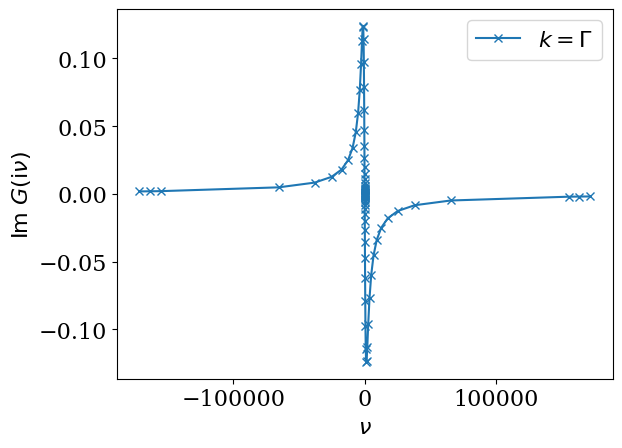

PyObject <matplotlib.legend.Legend object at 0x14dce0eea4f0>

In [5]:
iv = (im * π/beta) * smpl_matsu.sampling_points
gkf = 1.0 ./ (iv[:,newaxis] .- vec(ek)[newaxis,:])

plt.plot(smpl_matsu.sampling_points, imag(gkf[:,1]), label=L"$k=\Gamma$", marker="x")
plt.xlabel(L"$\nu$")
plt.ylabel(L"$\mathrm{Im}~G(\mathrm{i}\nu)$")
plt.legend()

## Step 3
Evaluate the Green's function on sampling points in the imaginary-time domain

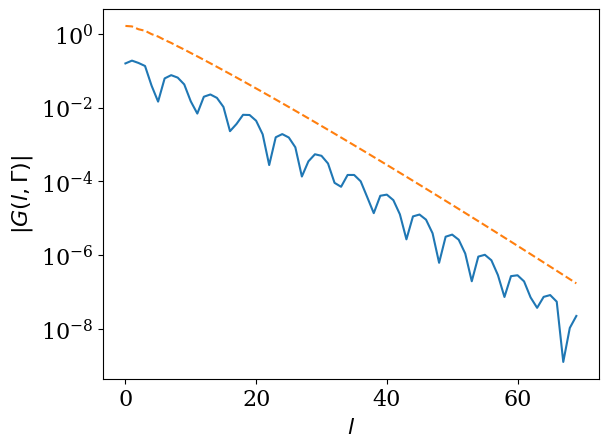

PyObject Text(35.0, 0.5, '$|G(l, \\Gamma)|$')

In [6]:
# G(l, k): (L, nk)
gkl = fit(smpl_matsu, gkf, axis=1)

@assert size(gkl) == (L, nk)

plt.semilogy(abs.(gkl[:,1]))
plt.semilogy(basis.s, ls="--")
plt.xlabel(L"$l$")
plt.ylabel(L"$|G(l, \Gamma)|$")

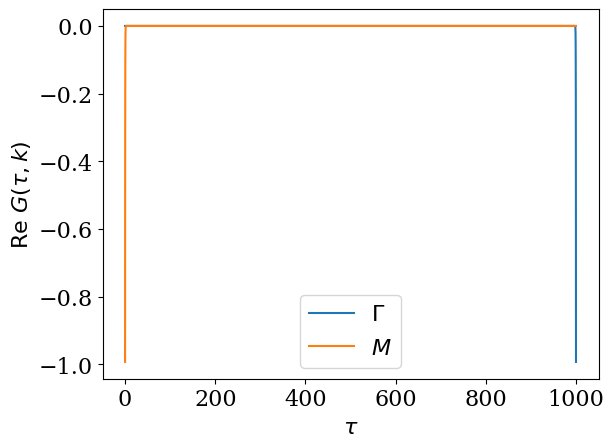

PyObject <matplotlib.legend.Legend object at 0x14dcd7fe7430>

In [7]:
gkt = evaluate(smpl_tau, gkl, axis=1)

@assert size(gkt) == (ntau, nk)

plt.plot(smpl_tau.sampling_points, real(gkt[:,1]), label=L"$\Gamma$")
plt.plot(smpl_tau.sampling_points, 
    reshape(real(gkt), ntau, kps...)[:,nk_lin÷2+1,nk_lin÷2+1], label=L"$M$")
plt.xlabel(L"$\tau$")
plt.ylabel(L"$\mathrm{Re}~G(\tau, k)$")
plt.legend()

## Step 4
Transform the Green's function to the real space and evaluate the self-energy

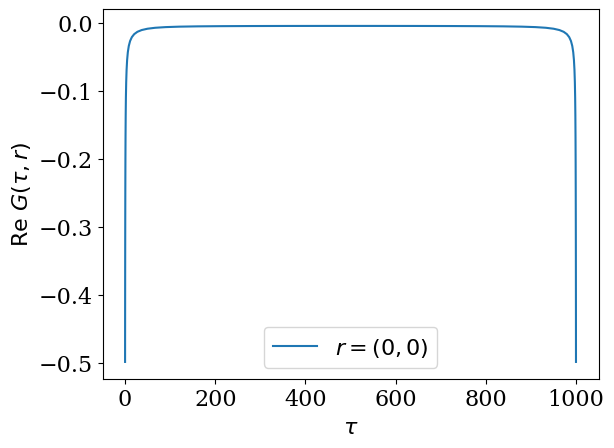

PyObject <matplotlib.legend.Legend object at 0x14dcde933460>

In [8]:
# Compute G(tau, r): (ntau, nk)
#  (1) Reshape gkt into shape of (ntau, nk_lin, nk_lin).
#  (2) Apply FFT to the axes 1, 2.
#  (3) Reshape the result to (ntau, nk)
# G(tau, k): (ntau, nk)
grt = fft(reshape(gkt, ntau, kps...), [2,3])
grt = reshape(grt, ntau, nk)/nk

plt.plot(smpl_tau.sampling_points, real(grt[:,1]), label=L"$r=(0,0)$")
plt.xlabel(L"$\tau$")
plt.ylabel(L"$\mathrm{Re}~G(\tau, r)$")
plt.legend()

Compute the second-order term of the self-energy on the sampling points

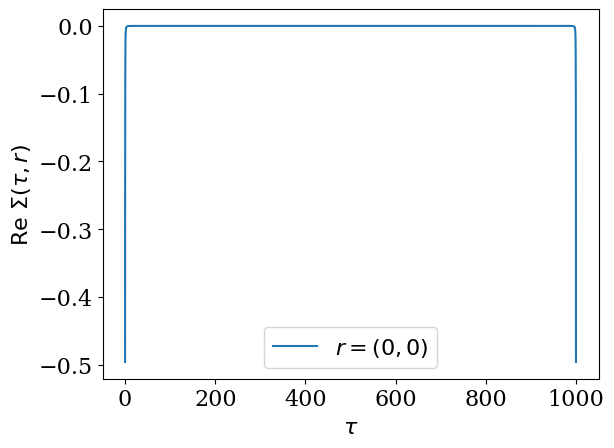

PyObject <matplotlib.legend.Legend object at 0x14dce0be9430>

In [9]:
# Sigma(tau, r): (ntau, nr)
# srt = (U*U) * (grt .* grt .* reverse(grt, dims=1))
srt = Array{Complex{Float64}}(undef, ntau, nr)
for ir=1:nr, itau=1:ntau
    srt[itau, ir] = (U*U) * (grt[itau, ir]^2) *  grt[ntau-itau+1, ir]
end

plt.plot(smpl_tau.sampling_points, real(srt[:,1]), label=L"$r=(0,0)$")
plt.xlabel(L"$\tau$")
plt.ylabel(L"$\mathrm{Re}~\Sigma(\tau, r)$")
plt.legend()

## Step 5
Tansform the self-energy to the IR basis and then transform it to the k spacre

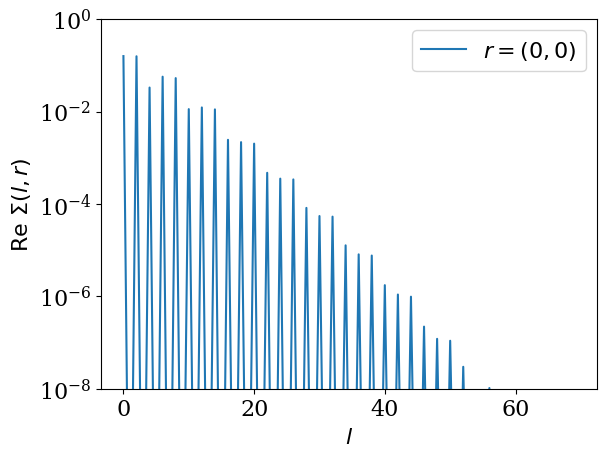

PyObject <matplotlib.legend.Legend object at 0x14dce0b56be0>

In [10]:
# Sigma(l, r): (L, nr)
srl = fit(smpl_tau, srt, axis=1)
@assert size(srl) == (L, nr)

plt.semilogy(abs.(srl[:,1]), label=L"$r=(0,0)$")
plt.xlabel(L"$l$")
plt.ylabel(L"$\mathrm{Re}~\Sigma(l, r)$")
plt.ylim([1e-8,1])
plt.legend()

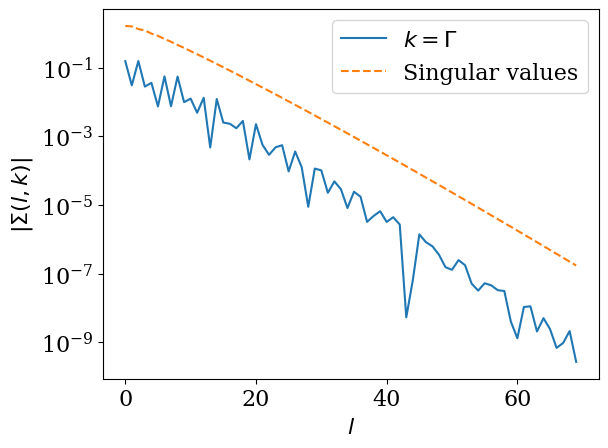

PyObject <matplotlib.legend.Legend object at 0x14dcd7fcbc10>

In [11]:
# Sigma(l, k): (L, nk)
srl = reshape(srl, L, kps...)
skl = ifft(srl, [2,3]) * nk
skl = reshape(skl, L, kps...)

plt.semilogy(abs.(skl[:,1,1]), label=L"$k=\Gamma$")
plt.semilogy(basis.s, label="Singular values", ls="--")
plt.xlabel(L"$l$")
plt.ylabel(L"$|\Sigma(l, k)|$")
plt.legend()

## Step 6
Evaluate the self-energy on arbitrary frequencies/times

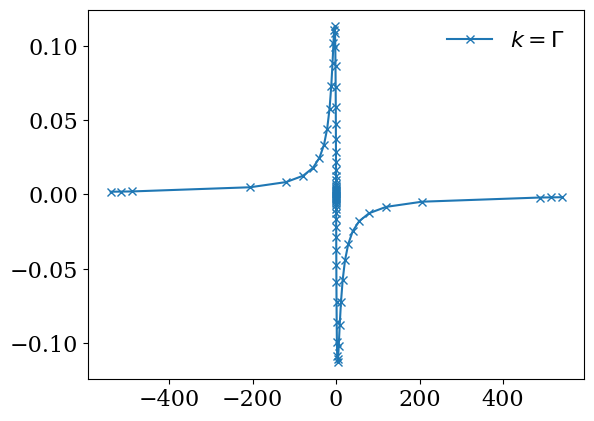

PyObject <matplotlib.legend.Legend object at 0x14dce0b2b9d0>

In [12]:
# Note: fermioic frequences must be represented by odd integers
#my_freqs = 2*np.arange(-100, 100)+1
my_freqs = smpl_matsu.sampling_points
uhat = basis.uhat(my_freqs)
@tensor res[w,I,J] := uhat[l,w] * skl[l,I,J]
plt.plot(my_freqs*(π/beta), imag(res[:,1,1]), marker="x", label=L"$k=\Gamma$")
plt.legend(frameon=false)